In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir(r'C:/Data')

In [3]:
dataset = pd.read_csv('ycdata.csv')

In [4]:
dataset.shape

(284807, 31)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

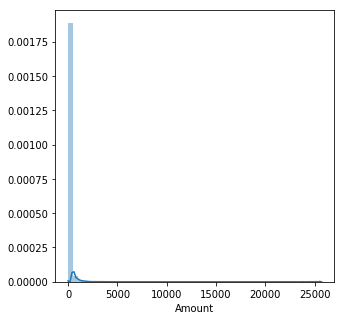

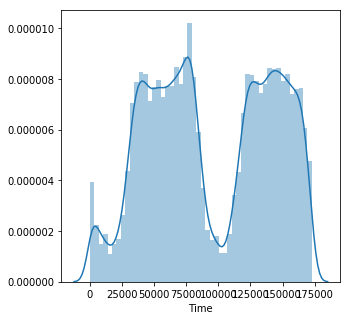

In [6]:
'''连续单变量密度分布图'''
col = ['Amount', 'Time']
for i in col:
    plt.figure(figsize=(5, 5))
    sns.distplot(dataset[i].dropna())
    plt.show()

In [7]:
'''对数转换'''
dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)

In [8]:
'''切分数据集'''
normal = dataset[dataset['Class'] == 0]
anomaly = dataset[dataset['Class'] == 1]

In [9]:
len(normal),len(anomaly)

(284315, 492)

In [10]:
from sklearn.model_selection import train_test_split as sp
train, test = sp(normal, test_size=0.2)
normal_valid, normal_test = sp(test, test_size=0.5)
anormal_valid, anormal_test = sp(anomaly, test_size=0.5)

In [11]:
print ('normal_train_data有:', len(train)) 
print ('normal_test_data有:', len(test))

normal_train_data有: 227452
normal_test_data有: 56863


In [12]:
print ('normal_valid有:', len(normal_valid)) 
print ('normal_test有:', len(normal_test))

normal_valid有: 28431
normal_test有: 28432


In [13]:
print ('anormal_valid有:', len(anormal_valid)) 
print ('anormal_test有:', len(anormal_test))

anormal_valid有: 246
anormal_test有: 246


In [14]:
train = train.reset_index(drop=True)

In [15]:
valid=pd.concat([normal_valid, anormal_valid])  
valid = valid.reset_index(drop=True)

In [16]:
test=pd.concat([normal_test, anormal_test])  
test = test.reset_index(drop=True)

# 基于高斯分布的异常值检测

In [17]:
'''计算协方差矩阵和均值'''
from scipy.stats import multivariate_normal
mu = train.drop('Class', axis=1).mean(axis=0).values  
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)  #多元正态分布，指定协方差、均值，允许奇异协方差矩阵

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values)))  #logpdf：概率密度函数对数
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 


-32.70869578464661
-752.994570311123


In [18]:
'''计算不同阈值下的recall_score、precision_score和fbeta_score'''
from sklearn.metrics import recall_score, precision_score, fbeta_score
tresholds = np.linspace(-1000, -10, 150)  
scores = []
for treshold in tresholds:
    y_valid_lable = (model.logpdf(valid.drop('Class', axis=1)) < treshold).astype(int)
    scores.append([recall_score(valid['Class'], y_valid_lable),        #召回率分数
                 precision_score(valid['Class'], y_valid_lable),       #命中率分数
                 fbeta_score(valid['Class'], y_valid_lable, beta=2)])  #精度和召回的加权调和平均值
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax()) 

0.7772435897435898 105


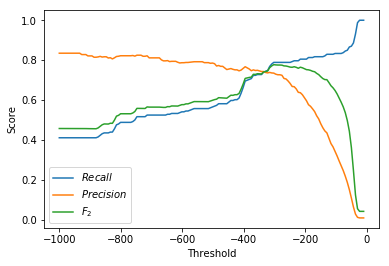

In [19]:
'''可视化不同阈值下的recall_score、precision_score和fbeta_score'''
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [20]:
'''计算测试集评价标准'''
final_tresh = tresholds[scores[:, 2].argmax()]
y_test_label = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('最终阈值是: %d' % final_tresh)
print('测试集召回率分数是: %.3f' % recall_score(test['Class'], y_test_label))
print('测试集命中率率分数是: %.3f' % precision_score(test['Class'], y_test_label))
print('测试集F2分数是: %.3f' % fbeta_score(test['Class'], y_test_label, beta=2))

最终阈值是: -302
测试集召回率分数是: 0.760
测试集命中率率分数是: 0.760
测试集F2分数是: 0.760


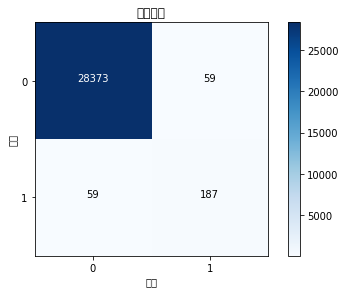

In [21]:
'''混淆矩阵可视化'''
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,title='混淆矩阵',cmap=plt.cm.Blues):
    #plt.figure(figsize = (5, 5))  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('实际')
    plt.xlabel('预测')    
cnf_matrix = confusion_matrix(test['Class'], y_test_label)     
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names)

# 基于混合高斯模型的异常值检测

In [22]:
'''混合高斯模型'''
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=1) 
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values)) 
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

6.4760723526343575
-126038.2185114365


In [ ]:
'''计算不同阈值下的recall_score、precision_score和fbeta_score'''
tresholds = np.linspace(-140000, 20, 1000)
scores = []
y_pred_score = gmm.score_samples(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_valid_lable = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(valid['Class'], y_valid_lable),        #召回率分数
                 precision_score(valid['Class'], y_valid_lable),       #命中率分数
                 fbeta_score(valid['Class'], y_valid_lable, beta=2)]) 
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.8048780487804879 998


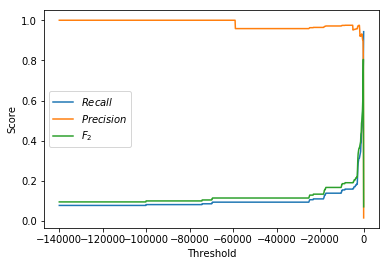

In [ ]:
'''可视化不同阈值下的recall_score、precision_score和fbeta_score'''
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
'''计算测试集评价标准'''
final_tresh = tresholds[scores[:, 2].argmax()]
y_test_label = (gmm.score_samples(
    test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('最终阈值是: %d' % final_tresh)
print('测试集召回率分数是: %.3f' % recall_score(test['Class'], y_test_label))
print('测试集命中率率分数是: %.3f' % precision_score(test['Class'], y_test_label))
print('测试集F2分数是: %.3f' % fbeta_score(test['Class'], y_test_label, beta=2))

最终阈值是: -120
测试集召回率分数是: 0.789
测试集命中率率分数是: 0.822
测试集F2分数是: 0.795


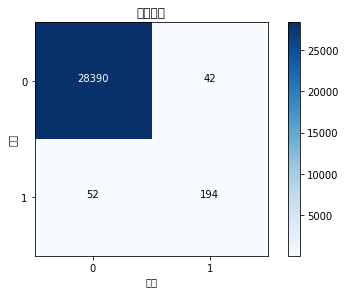

In [ ]:
cnf_matrix = confusion_matrix(test['Class'].values, y_test_label)
plot_confusion_matrix(cnf_matrix, classes=class_names)

# 基于孤立森林的异常值检测

In [ ]:
'''孤立森林模型'''
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=50, bootstrap=True, max_samples=train.shape[0], n_jobs=4, random_state=1)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

0.1448690113155185
-0.05593973989731047


In [ ]:
'''计算不同阈值下的recall_score、precision_score和fbeta_score'''
tresholds = np.linspace(-0.2, 0.2, 200)
scores = []
y_pred_score = model.decision_function(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_valid_lable = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(valid['Class'], y_valid_lable),  # 召回率分数
                   precision_score(valid['Class'], y_valid_lable),  # 命中率分数
                   fbeta_score(valid['Class'], y_valid_lable, beta=2)])
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())  # fbeta最大为0.68，索引是124

0.6777856635911994 123


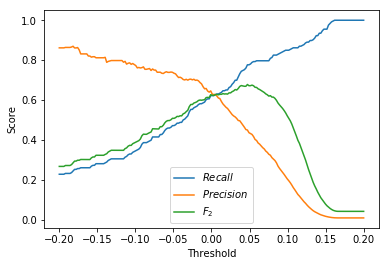

In [ ]:
'''可视化不同阈值下的recall_score、precision_score和fbeta_score'''
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

最终阈值是: 0
测试集召回率分数是: 0.760
测试集命中率率分数是: 0.448
测试集F2分数是: 0.667


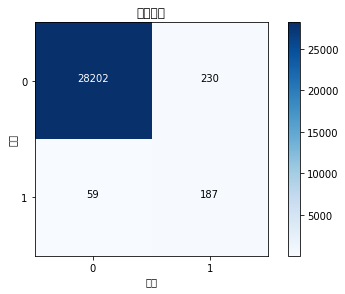

In [ ]:
'''计算测试集评价标准'''
final_tresh = tresholds[scores[:, 2].argmax()]
y_test_label = (model.decision_function(
    test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('最终阈值是: %d' % final_tresh)
print('测试集召回率分数是: %.3f' % recall_score(test['Class'], y_test_label))
print('测试集命中率率分数是: %.3f' % precision_score(test['Class'], y_test_label))
print('测试集F2分数是: %.3f' % fbeta_score(test['Class'], y_test_label, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_test_label)
plot_confusion_matrix(cnf_matrix, classes=class_names)

# 基于直方图的异常值检测

In [ ]:
'''直方图探索：摆脱了高斯分布的限制，但是没有捕捉到变量之间的关系'''


class hist_model(object):
    def __init__(self, bins=50):
        self.bins = bins

    def fit(self, X):
        bin_hight, bin_edge = [], []
        for var in X.T:
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)

    def predict(self, X):
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num])
            scores.append(np.mean(obs_score))
        return np.array(scores)


model = hist_model()
# 为每个特征建立直方图，将bin的高度合并为分数，如果分数很低，说明异常
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(
    valid[valid['Class'] == 0].drop('Class', axis=1).values)))
print(np.median(model.predict(
    valid[valid['Class'] == 1].drop('Class', axis=1).values)))

64610.333333333336
33032.433333333334


In [ ]:
'''计算不同阈值下的recall_score、precision_score和fbeta_score'''
tresholds = np.linspace(10000, 80000, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_valid_lable = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(valid['Class'], y_valid_lable),  # 召回率分数
                   precision_score(valid['Class'], y_valid_lable),  # 命中率分数
                   fbeta_score(valid['Class'], y_valid_lable, beta=2)])
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())  # fbeta最大为0.42，索引是42

0.3428571428571428 37


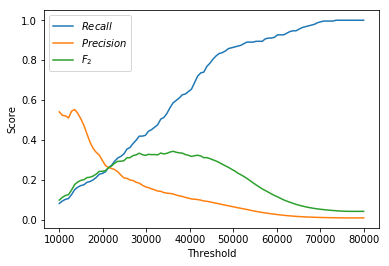

In [ ]:
'''可视化不同阈值下的recall_score、precision_score和fbeta_score'''
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
'''计算测试集评价标准'''
final_tresh = tresholds[scores[:, 2].argmax()]
y_test_label = (model.predict(test.drop('Class', axis=1).values)
                < final_tresh).astype(int)

In [ ]:
print('最终阈值是: %d' % final_tresh)
print('测试集召回率分数是: %.3f' % recall_score(test['Class'], y_test_label))
print('测试集命中率率分数是: %.3f' % precision_score(test['Class'], y_test_label))
print('测试集F2分数是: %.3f' % fbeta_score(test['Class'], y_test_label, beta=2))

最终阈值是: 36161
测试集召回率分数是: 0.602
测试集命中率率分数是: 0.134
测试集F2分数是: 0.354


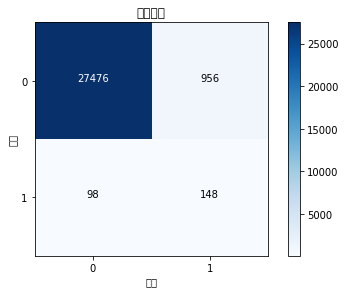

In [ ]:
cnf_matrix = confusion_matrix(test['Class'].values, y_test_label)
plot_confusion_matrix(cnf_matrix, classes=class_names)

# 基于SVM的异常值检测

In [ ]:
'''一类svm，用于异常值检测'''
from sklearn.svm import OneClassSVM

model = OneClassSVM()
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(
    valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(
    valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

In [ ]:
'''计算不同阈值下的recall_score、precision_score和fbeta_score'''
tresholds = np.linspace(-50000, -400, 500)
scores = []
y_pred_score = model.decision_function(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_valid_lable = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(valid['Class'], y_valid_lable),        #召回率分数
                 precision_score(valid['Class'], y_valid_lable),       #命中率分数
                 fbeta_score(valid['Class'], y_valid_lable, beta=2)]) 
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())  #fbeta最大为0.81，索引是68


In [ ]:
'''可视化不同阈值下的recall_score、precision_score和fbeta_score'''
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
'''计算测试集评价标准'''
final_tresh = tresholds[scores[:, 2].argmax()]
y_test_label = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

In [ ]:
print('最终阈值是: %d' % final_tresh)
print('测试集召回率分数是: %.3f' % recall_score(test['Class'], y_test_label))
print('测试集命中率率分数是: %.3f' % precision_score(test['Class'], y_test_label))
print('测试集F2分数是: %.3f' % fbeta_score(test['Class'], y_test_label, beta=2))

In [ ]:
cnf_matrix = confusion_matrix(test['Class'].values, y_test_label)
plot_confusion_matrix(cnf_matrix, classes=class_names)
